# Training A Classifier

Here I follow the pyTorch [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network) on a Convolutional Neural Network for image classification.

## import.STONKS()

Ya know da drill:

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from os.path import exists

# Path for where we save the model
# this is a magic tool that will come in handy later ;)
saveModelPath = "../trainedModels/basic_cifar_net.pth"

## Important if you want to train again, set this to True
trainAgain = False

## DATA
First we need some data wich we can download with Torch.

This data needs to be normalized!

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root="../data/datasetCIFAR", train=True, download=True, transform=transform
    )

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )

testset = torchvision.datasets.CIFAR10(
    root="../data/datasetCIFAR", train=False, download=True, transform=transform
    )

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size,shuffle=False, num_workers=2
    )

# classes = ("plane", "car", "bird", "cat",
#           "deer", "dog", "frog", "horse", "ship", "truck")

bla = trainset.classes
print(bla)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Show some images

Because we have done it so much now. It has just become tradition. We need to see some of dem images!

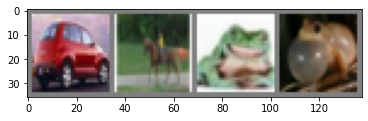

car   horse frog  frog 


In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
# The "iter( )" function makes an object iterable.
# Meaning that we still can't subscribt it, however we can call the next 
# "instance" (I guess is an apt name), over and over. 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

## Defining neural network
The neural network obviously needs to be defined.
So here we see an example on how to define a Convolutional Neural Network (CNN).

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # I am quite certain that 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = CNN()

## Defining loss and optimizer

We also need to define an optimizer (function) and a loss (function). Business as usual.

In [5]:
lrn_rt = 0.5e-3

# I am unsure as to why loss is called criterion here
loss_fn = nn.CrossEntropyLoss()
# We are just going to use Adam, because it has proven to be effective.
optimizer = optim.Adam(model.parameters(), lr=lrn_rt)

## The Training and Testing Loop

The loops for training and testing:

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    
    for batch, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Compute prediction and loss
        pred = model(inputs)
        loss = loss_fn(pred, labels)
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches        
    correct /= size
    return 100*correct, train_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data in dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            pred = model(inputs)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return 100*correct, test_loss

## Training the network

Obviously we also need to fit some weights, so here is the code for training the network.

In [7]:
# exists is a function from os.path (standard library)
trained_model_exists = exists(saveModelPath)

# We train if we haven't already trained
# or we want to train again.
if not trained_model_exists or trainAgain:
    epochs = 8
    accuracies = [[0]*epochs, [0]*epochs]
    losses = [[0]*epochs, [0]*epochs]

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        accuracyTrain, avglossTrain = train_loop(trainloader, model, loss_fn, optimizer)
        accuracyTest, avglossTest = test_loop(testloader, model, loss_fn)
        
        # This is just extra for plotting
        accuracies[0][t] = accuracyTest
        accuracies[1][t] = accuracyTrain
        losses[0][t] = avglossTest
        losses[1][t] = avglossTrain
    print("Done!")
    
else:
    print("Have already trained this model once!")


Epoch 1
-------------------------------
loss: 2.265167  [    0/50000]
loss: 1.989170  [ 4000/50000]
loss: 1.643174  [ 8000/50000]
loss: 1.318648  [12000/50000]
loss: 1.830855  [16000/50000]
loss: 2.265515  [20000/50000]
loss: 0.717968  [24000/50000]
loss: 2.119205  [28000/50000]
loss: 1.068044  [32000/50000]
loss: 1.122327  [36000/50000]
loss: 2.903266  [40000/50000]
loss: 2.304609  [44000/50000]
loss: 1.832392  [48000/50000]
Test Error: 
 Accuracy: 51.9%, Avg loss: 1.340785 

Epoch 2
-------------------------------
loss: 0.763880  [    0/50000]
loss: 2.338177  [ 4000/50000]
loss: 3.191738  [ 8000/50000]
loss: 2.146995  [12000/50000]
loss: 1.544610  [16000/50000]
loss: 0.464244  [20000/50000]
loss: 0.765905  [24000/50000]
loss: 0.964963  [28000/50000]
loss: 1.650567  [32000/50000]
loss: 0.910978  [36000/50000]
loss: 1.314003  [40000/50000]
loss: 0.659637  [44000/50000]
loss: 0.751917  [48000/50000]
Test Error: 
 Accuracy: 57.2%, Avg loss: 1.213897 

Epoch 3
----------------------------

### Optional code for plotting
If you wanna see the development of the accuracy and the avg loss, this is the plot for you!

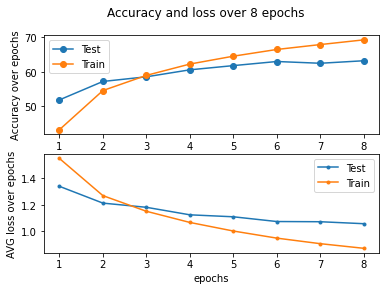

In [9]:
# Only run this if we have trained, so that we have an available plot
if not trained_model_exists or trainAgain:
    xVals = list(range(1, epochs + 1))

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle(f"Accuracy and loss over {epochs} epochs")

    ax1.plot(xVals, accuracies[0], 'o-', label="Test")
    ax1.plot(xVals, accuracies[1], 'o-', label="Train")
    ax1.legend()
    ax1.set_ylabel("Accuracy over epochs")

    ax2.plot(xVals, losses[0], '.-', label="Test")
    ax2.plot(xVals, losses[1], '.-', label="Train")
    ax2.legend()
    ax2.set_xlabel("epochs")
    ax2.set_ylabel("AVG loss over epochs")
    
    plt.show()
else:
    print("We didn't train, so we can't plot anything...")



### A quick save
Saving the model real quick

In [10]:
if not trained_model_exists or trainAgain:
    torch.save(model.state_dict(), saveModelPath)
    print(f"Saved PyTorch Model State to {saveModelPath}")

Saved PyTorch Model State to ../trainedModels/basic_cifar_net.pth


## Testing the network on the Test data

Pretty much what it says. We are always interested in testing the model on some random testing data.


shape of the images 'Tensor': torch.Size([4, 3, 32, 32])


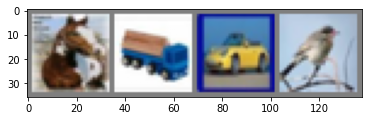

GroundTruth:  horse truck car   bird 


In [11]:
images, labels = dataiter.next()

print(f"shape of the images 'Tensor': {images.shape}")
# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

Loading the model back in (if necessary)

In [12]:
net = CNN()
net.load_state_dict(torch.load(saveModelPath))


<All keys matched successfully>

The scores from the newtork

In [13]:
outputs = net(images)

How it predicts

In [14]:
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

Predicted:  horse truck car   bird 


## SUS code and questions

I do not understand why the testset looks so different from the test loader. The test loader seems to be an object created from the "test-dataset". 
The main difference between the two seems to solely be that, the "test-dataset" is a subscribtable object, wheras the "test-dataloader" isn't.

The following code shows four random pictures from the testset and also the four next picture from the testloader.

random index: tensor([9922, 2034, 1978, 4789])
number of data points: 10000


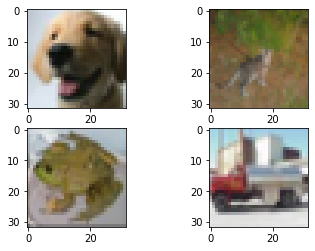

In [15]:
N_DataPoints = len(testset)
sample_idx = torch.randint(N_DataPoints, size=(4,))
print(f"random index: {sample_idx}")
print(f"number of data points: {N_DataPoints}")

fig = plt.figure()
for i, indx in enumerate(sample_idx):
    indx = indx.item()
    
    ax = fig.add_subplot(2, 2, i + 1)
    tensor_im = testset[indx][0]
    #print(f"Shape of im before reshape: {tensor_im.shape}")
    reshaped_im = tensor_im.permute(1, 2, 0) # this reshaping function is concise :)!
    #print(f"Shape of im after reshape: {reshaped_im.shape}")
    
    # now we should unnormalize the image! 
    # Option A: we can normalize the range of the pixel values from [-1, 1] -> [0, 1]
    normalized_reshaped_im = reshaped_im/2 + 0.5
    
    # Option B: we can normalize the range of the pixel values from [-1, 1] -> [0, 255] (this is just option A x 255.!)
    # reshaped_im = (reshaped_im+1)*127.5
    # reshaped_im = reshaped_im.detach().cpu().numpy().astype(np.uint8)
    
    imgplot = plt.imshow(normalized_reshaped_im)

shape of the images 'Tensor': torch.Size([4, 3, 32, 32])


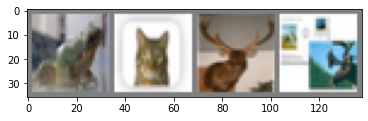

GroundTruth:  frog  cat   deer  deer 


In [16]:
images, labels = dataiter.next()

print(f"shape of the images 'Tensor': {images.shape}")
# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

## Note on Code for Training

So I spent a good amount of time examning theese two different examples of code. In short: ...They do the same.

I prefer the first one, as it is nicer formatted and it has bit more information. The weird thing is that they are both from pyTorch's tutorial sites.

In [17]:
"""
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, model, loss_fn, optimizer)
    test_loop(testloader, model, loss_fn)
print("Done!")
"""

'\ndef train_loop(dataloader, model, loss_fn, optimizer):\n    size = len(dataloader.dataset)\n    for batch, data in enumerate(dataloader):\n        # get the inputs; data is a list of [inputs, labels]\n        inputs, labels = data\n        \n        # Compute prediction and loss\n        pred = model(X)\n        loss = loss_fn(pred, y)\n\n        # Backpropagation\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        if batch % 100 == 0:\n            loss, current = loss.item(), batch * len(X)\n            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")\n\n\ndef test_loop(dataloader, model, loss_fn):\n    size = len(dataloader.dataset)\n    num_batches = len(dataloader)\n    test_loss, correct = 0, 0\n\n    with torch.no_grad():\n        for X, y in dataloader:\n            pred = model(X)\n            test_loss += loss_fn(pred, y).item()\n            correct += (pred.argmax(1) == y).type(torch.float).sum().item()\n\n    test_loss /= num

In [18]:
"""
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
"""

"\nfor epoch in range(10):  # loop over the dataset multiple times\n\n    running_loss = 0.0\n    for i, data in enumerate(trainloader):\n        # get the inputs; data is a list of [inputs, labels]\n        inputs, labels = data\n\n        # zero the parameter gradients\n        optimizer.zero_grad()\n\n        # forward + backward + optimize\n        outputs = model(inputs)\n        loss = loss_fn(outputs, labels)\n        loss.backward()\n        optimizer.step()\n\n        # print statistics\n        running_loss += loss.item()\n        if i % 2000 == 1999:    # print every 2000 mini-batches\n            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')\n            running_loss = 0.0\n\nprint('Finished Training')\n"